In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Flatten, MaxPooling1D, Dropout, AveragePooling1D, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import tensorflow as tf

2024-12-13 23:40:29.836894: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-13 23:40:29.867854: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-13 23:40:29.867882: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-13 23:40:29.867910: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-13 23:40:29.875453: I tensorflow/core/platform/cpu_feature_g

In [2]:
# 1. Preparación de Datos
data = pd.read_csv("monthly_milk_production.csv")
data.columns = ["Date", "Milk_Production"]
data["Date"] = pd.to_datetime(data["Date"])
data.set_index("Date", inplace=True)

In [3]:
# Escalar datos
data_values = data["Milk_Production"].values.reshape(-1, 1)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_values)

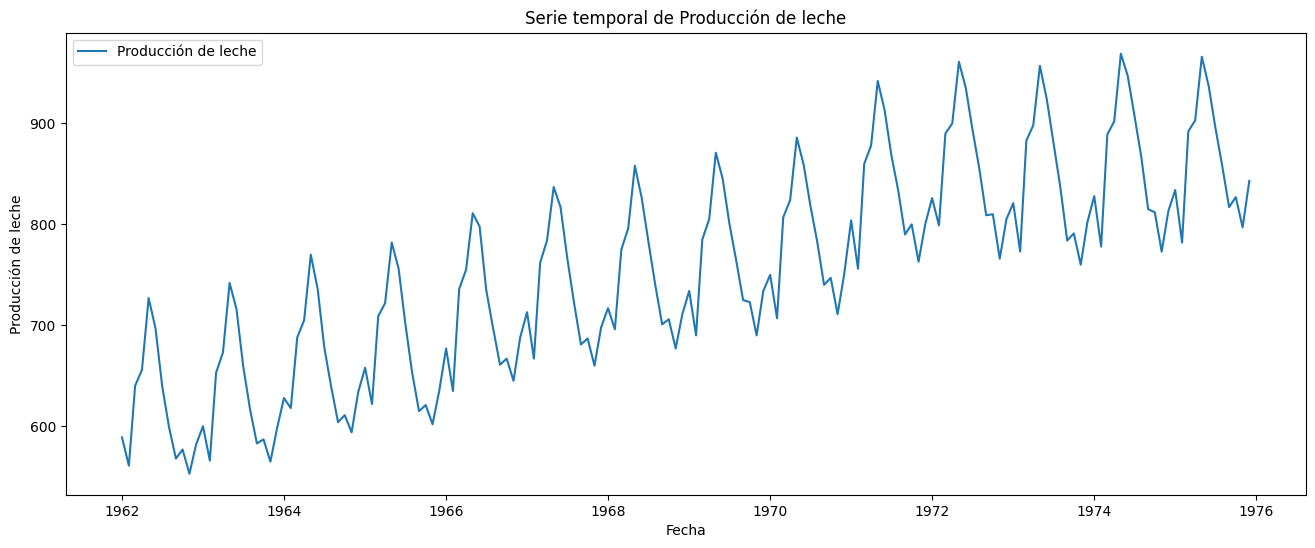

In [4]:
# 2. Visualización de la serie temporal
plt.figure(figsize=(16, 6))
plt.plot(data.index, data["Milk_Production"], label="Producción de leche")
plt.title("Serie temporal de Producción de leche")
plt.xlabel("Fecha")
plt.ylabel("Producción de leche")
plt.legend()
plt.show()

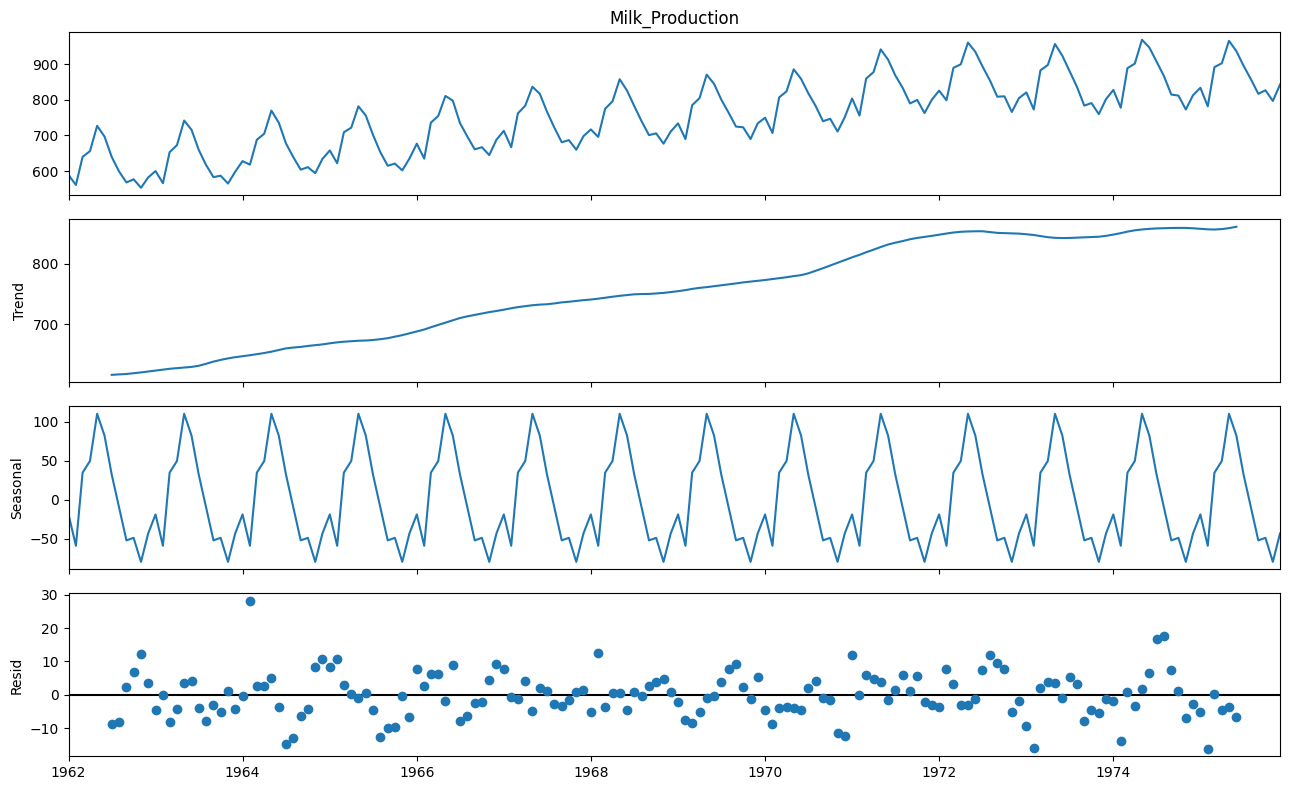

In [5]:
# 3. Análisis de la serie temporal
decomposition = seasonal_decompose(data["Milk_Production"], model="additive", period=12)
fig_decomposition = decomposition.plot()
fig_decomposition.set_size_inches((13, 8))
fig_decomposition.tight_layout()
plt.show()

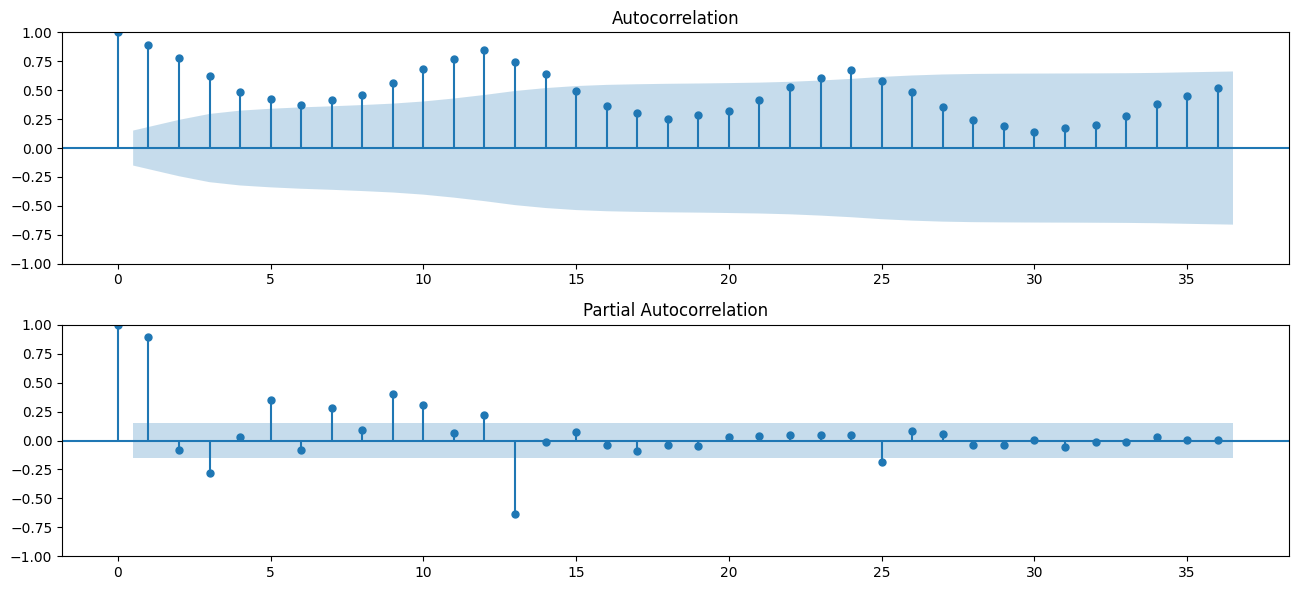

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(13, 6)) 
plot_acf(data, lags=36, alpha=0.05, ax=axes[0])
plot_pacf(data, lags=36, alpha=0.05, ax=axes[1])
plt.tight_layout()
plt.show()

In [7]:
# 4. Separación de datos para LSTM
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

n_steps = 12
X, y = create_sequences(data_scaled, n_steps)
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

In [8]:
# 5. Modelo LSTM
seed = 123123
np.random.seed(seed)
tf.random.set_seed(seed)

model_lstm = Sequential([
    LSTM(64, activation="relu", dropout=0.25, return_sequences=True, kernel_initializer='glorot_uniform', input_shape=(n_steps, 1)),
    LSTM(32, activation="relu", dropout=0.25),
    Dense(1, activation='linear')
])

# hiperparametros
epochs_ = 200
batch_size_ = 16
shuffle_ = False
patience_ = 30
lr_ = 0.001
loss_ = "mse"

model_lstm.compile(optimizer=Adam(learning_rate=lr_), loss=loss_)
model_lstm.summary()

es = EarlyStopping(monitor="val_loss", patience=patience_, restore_best_weights=True)
history_lstm = model_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs_, batch_size=batch_size_, shuffle=shuffle_, callbacks=[es])

2024-12-13 23:40:32.242625: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-13 23:40:32.246748: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-13 23:40:32.246789: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-13 23:40:32.249319: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-13 23:40:32.249366: I tensorflow/compile

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29345 (114.63 KB)
Trainable params: 29345 (114.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200


2024-12-13 23:40:35.175194: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f01343dd630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-13 23:40:35.175226: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-12-13 23:40:35.178566: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-13 23:40:35.189981: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-12-13 23:40:35.253838: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 [==============================] - 4s 103ms/step - loss: 0.1906 - val_loss: 0.4245
Epoch 2/200
7/7 [==============================] - 0s 67ms/step - loss: 0.1212 - val_loss: 0.2487
Epoch 3/200
7/7 [==============================] - 0s 68ms/step - loss: 0.0488 - val_loss: 0.0630
Epoch 4/200
7/7 [==============================] - 0s 71ms/step - loss: 0.0268 - val_loss: 0.0256
Epoch 5/200
7/7 [==============================] - 0s 67ms/step - loss: 0.0393 - val_loss: 0.0367
Epoch 6/200
7/7 [==============================] - 0s 69ms/step - loss: 0.0313 - val_loss: 0.0600
Epoch 7/200
7/7 [==============================] - 0s 68ms/step - loss: 0.0293 - val_loss: 0.0507
Epoch 8/200
7/7 [==============================] - 0s 69ms/step - loss: 0.0266 - val_loss: 0.0354
Epoch 9/200
7/7 [==============================] - 0s 68ms/step - loss: 0.0289 - val_loss: 0.0330
Epoch 10/200
7/7 [==============================] - 1s 129ms/step - loss: 0.0289 - val_loss: 0.0388
Epoch 11/200
7/7 [===========

In [9]:
# Evaluación y métricas en LSTM
lstm_predictions = model_lstm.predict(X_test)
lstm_predictions_rescaled = scaler.inverse_transform(lstm_predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

mse_lstm = mean_squared_error(y_test_rescaled, lstm_predictions_rescaled)
mae_lstm = mean_absolute_error(y_test_rescaled, lstm_predictions_rescaled)
print(f"LSTM - MSE: {mse_lstm:.4f}, MAE: {mae_lstm:.4f}")

1/1 [==============================] - 0s 191ms/step
LSTM - MSE: 2542.5212, MAE: 46.1953


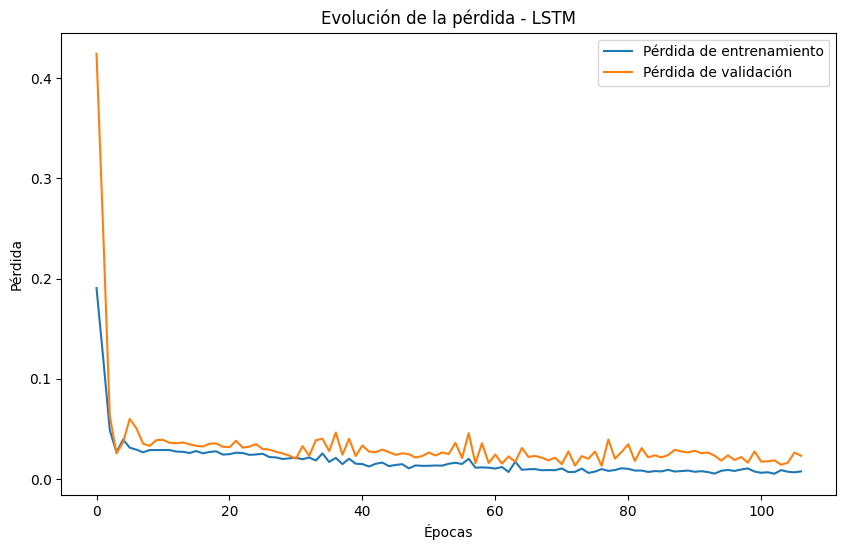

In [10]:
# Visualizar pérdidas del modelo LSTM
plt.figure(figsize=(10, 6))
plt.plot(history_lstm.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history_lstm.history['val_loss'], label='Pérdida de validación')
plt.title('Evolución de la pérdida - LSTM')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

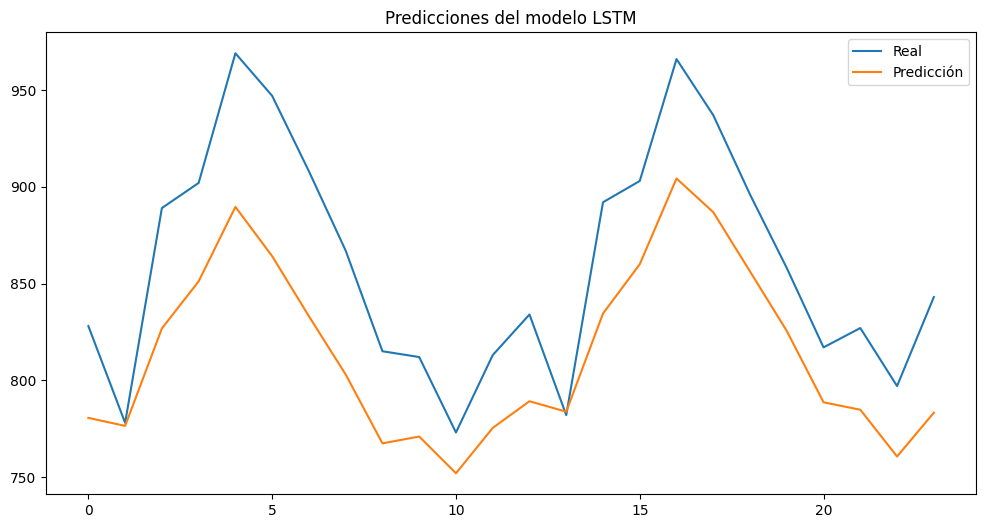

In [11]:
# Visualizar predicciones
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Real")
plt.plot(lstm_predictions_rescaled, label="Predicción")
plt.legend()
plt.title("Predicciones del modelo LSTM")
plt.show()

In [12]:
# 6. Modelo LSTM + Conv1D
seed = 123123
np.random.seed(seed)
tf.random.set_seed(seed)

model_lstm_conv = Sequential([
    Conv1D(32, kernel_size=2, activation=LeakyReLU(alpha=0.85), input_shape=(n_steps, 1)),
    #MaxPooling1D(pool_size=2),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    Conv1D(64, kernel_size=2, activation=LeakyReLU(alpha=0.85)),
    #MaxPooling1D(pool_size=2),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    LSTM(64, activation="relu", dropout=0.25, kernel_initializer='glorot_uniform', return_sequences=True),
    LSTM(32, activation="relu", dropout=0.25),
    Dense(1, activation='linear')
])

model_lstm_conv.compile(optimizer=Adam(learning_rate=lr_), loss=loss_)
model_lstm_conv.summary()

history_conv = model_lstm_conv.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs_, batch_size=batch_size_, shuffle=shuffle_, callbacks=[es])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 11, 32)            96        
                                                                 
 average_pooling1d (Average  (None, 5, 32)             0         
 Pooling1D)                                                      
                                                                 
 dropout (Dropout)           (None, 5, 32)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 4, 64)             4160      
                                                                 
 average_pooling1d_1 (Avera  (None, 2, 64)             0         
 gePooling1D)                                                    
                                                                 
 dropout_1 (Dropout)         (None, 2, 64)            

In [13]:
# Evaluación y métricas en LSTM + Conv1D
conv_predictions = model_lstm_conv.predict(X_test)
conv_predictions_rescaled = scaler.inverse_transform(conv_predictions)

mse_conv = mean_squared_error(y_test_rescaled, conv_predictions_rescaled)
mae_conv = mean_absolute_error(y_test_rescaled, conv_predictions_rescaled)
print(f"LSTM + Conv1D - MSE: {mse_conv:.4f}, MAE: {mae_conv:.4f}")

1/1 [==============================] - 0s 402ms/step
LSTM + Conv1D - MSE: 433.4614, MAE: 16.9959


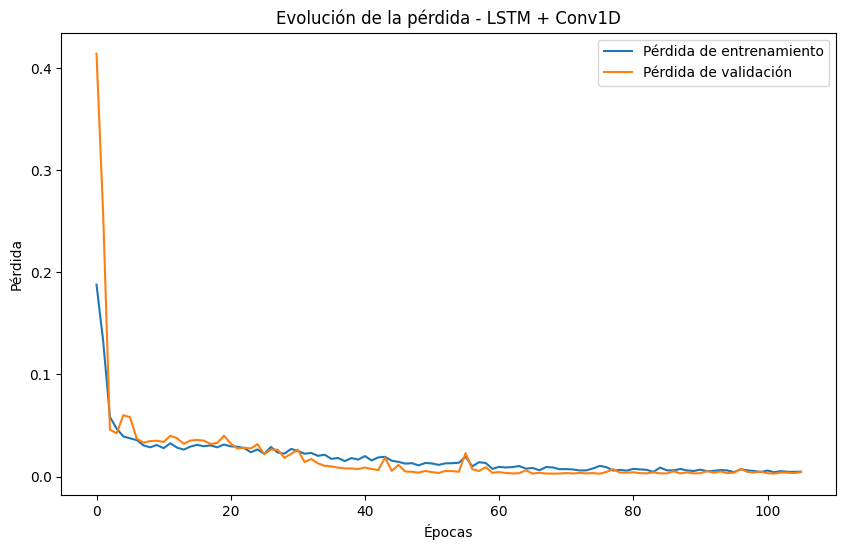

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(history_conv.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history_conv.history['val_loss'], label='Pérdida de validación')
plt.title('Evolución de la pérdida - LSTM + Conv1D')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

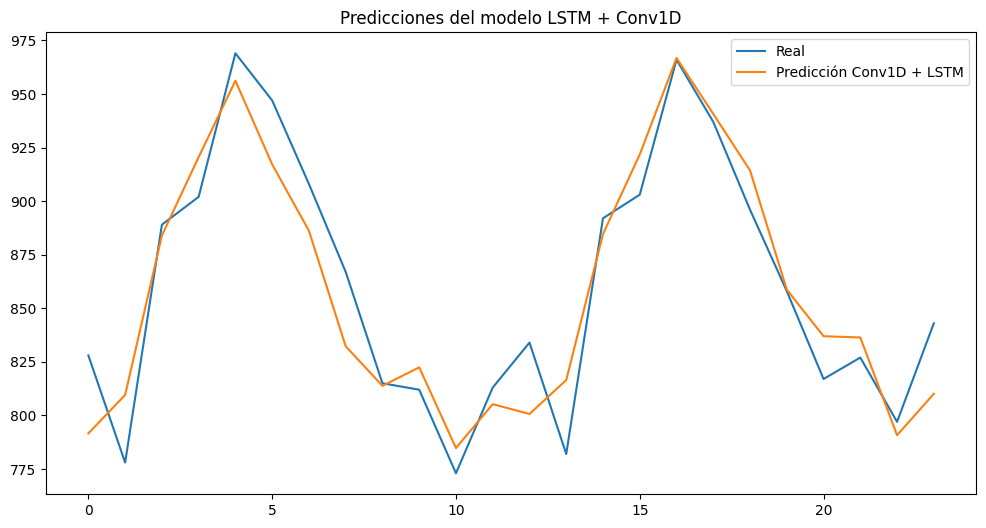

In [15]:
# Visualizar predicciones
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Real")
plt.plot(conv_predictions_rescaled, label="Predicción Conv1D + LSTM")
plt.legend()
plt.title("Predicciones del modelo LSTM + Conv1D")
plt.show()

In [16]:
# 7. Comparación de resultados
print(f"MSE Comparación: LSTM ({mse_lstm:.4f}), LSTM + Conv1D ({mse_conv:.4f})")
print(f"MAE Comparación: LSTM ({mae_lstm:.4f}), LSTM + Conv1D ({mae_conv:.4f})")

#MSE Comparación: LSTM (731.4277), LSTM + Conv1D (522.6597)
#MAE Comparación: LSTM (23.5468), LSTM + Conv1D (18.4108)

MSE Comparación: LSTM (2542.5212), LSTM + Conv1D (433.4614)
MAE Comparación: LSTM (46.1953), LSTM + Conv1D (16.9959)


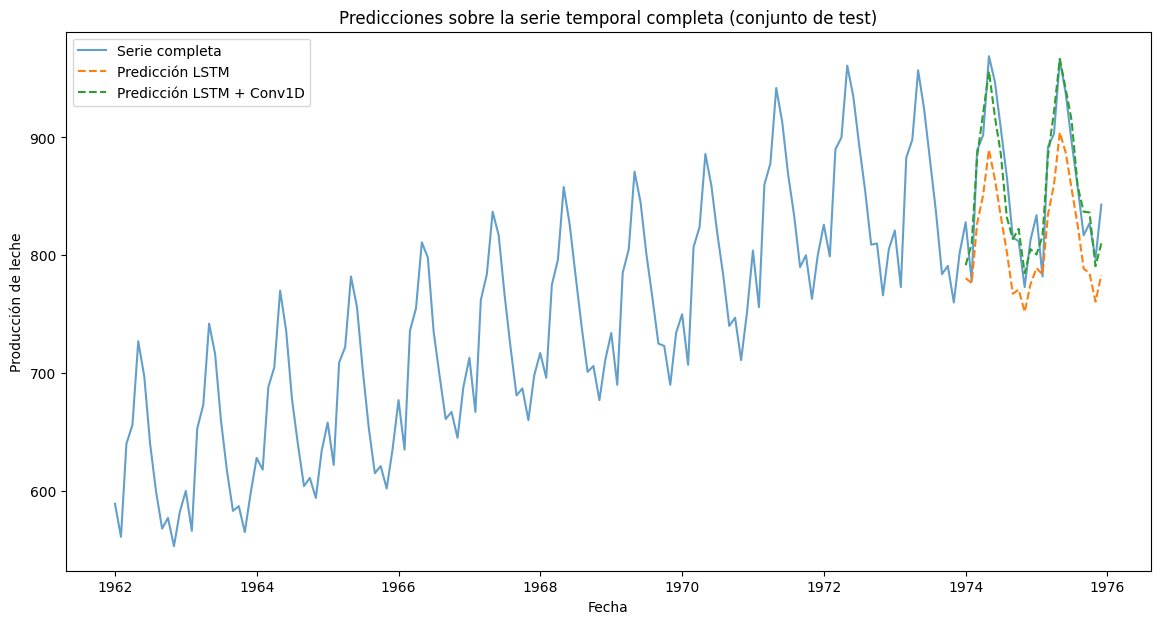

In [17]:
# Visualizar predicciones sobre la serie completa
all_data_index = data.index[-len(y_test_rescaled):]
plt.figure(figsize=(14, 7))
plt.plot(data.index, data["Milk_Production"], label="Serie completa", alpha=0.7)
plt.plot(all_data_index, lstm_predictions_rescaled, label="Predicción LSTM", linestyle="--")
plt.plot(all_data_index, conv_predictions_rescaled, label="Predicción LSTM + Conv1D", linestyle="--")
plt.title("Predicciones sobre la serie temporal completa (conjunto de test)")
plt.xlabel("Fecha")
plt.ylabel("Producción de leche")
plt.legend()
plt.show()